In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib  inline

In [9]:
# # of states except for terminal states
N_STATES = 100

# true state values, just a promising guess
trueStateValues = np.arange(-101, 103, 2) / 101.0
targetV = trueStateValues.copy()

# all states
states = np.arange(1, N_STATES + 1)

# start from a central state
START_STATE = 50

# terminal states
END_STATES = [0, N_STATES + 1]

# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]

# maximum stride for an action
STEP_RANGE = 10

# Dynamic programming to find the true state values, based on the promising guess above
# Assume all rewards are 0, given that we have already given value -1 and 1 to terminal states
while True:
    oldTrueStateValues = np.copy(trueStateValues)
    for state in states:
        trueStateValues[state] = 0
        for action in ACTIONS:
            for step in range(1, STEP_RANGE + 1):
                step *= action
                newState = state + step
                newState = max(min(newState, N_STATES + 1), 0)
                # asynchronous update for faster convergence
                trueStateValues[state] += 1.0 / (2 * STEP_RANGE) * trueStateValues[newState]
    error = np.sum(np.abs(oldTrueStateValues - trueStateValues))
    print(error)
    if error < 1e-2:
        break
# correct the state value for terminal states to 0
trueStateValues[0] = trueStateValues[-1] = 0

0.5076256610837646
0.2980700824190591
0.22864337370274468
0.1911613443764567
0.16505221258404923
0.14441815744620676
0.1270174331370749
0.11194237087982042
0.09874578554550117
0.08712187699641002
0.07689417511303201
0.06788876380703225
0.059941705373152375
0.05293106340570318
0.04673912206087266
0.04126081489683462
0.036412590278797896
0.03212544300628135
0.028349812759121282
0.02501782764673286
0.022083288525455342
0.019504645179984972
0.017244816598123627
0.015270037932505242
0.013545761023790263
0.012043910022518358
0.010741460313947217
0.00961406675500587


# Mountain-Car Problem

In [3]:
basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if isinstance(m, IHT): return m.getindex(tuple(coordinates), readonly)
    if isinstance(m, int): return basehash(tuple(coordinates)) % m
    if m is None: return coordinates

from math import floor, log
from six.moves import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [10]:
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def calc_H(x, bins):
    c_x = np.histogram(x,bins)[0]
    H = entropy(c_x)
    return H


In [95]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
#from TileCoding import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# all possible actions
ACTION_REVERSE = -1
ACTION_ZERO = 0
ACTION_FORWARD = 1
# order is important
ACTIONS = [ACTION_REVERSE, ACTION_ZERO, ACTION_FORWARD]

# bound for position and velocity
POSITION_MIN = -1.2
POSITION_MAX = 0.5
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07

##### bins for MI calculation
mibins = 10

# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0

# take an @action at @position and @velocity
# @return: new position, new velocity, reward (always -1)
def takeAction(position, velocity, action):
    newVelocity = velocity + 0.001 * action - 0.0025 * np.cos(3 * position)
    newVelocity = min(max(VELOCITY_MIN, newVelocity), VELOCITY_MAX)
    newPosition = position + newVelocity
    newPosition = min(max(POSITION_MIN, newPosition), POSITION_MAX)
    reward = -1.0
    if newPosition == POSITION_MIN:
        newVelocity = 0.0
    return newPosition, newVelocity, reward

# wrapper class for state action value function
class ValueFunction:
    # In this example I use the tiling software instead of implementing standard tiling by myself
    # One important thing is that tiling is only a map from (state, action) to a series of indices
    # It doesn't matter whether the indices have meaning, only if this map satisfy some property
    # View the following webpage for more information
    # http://incompleteideas.net/sutton/tiles/tiles3.html
    # @maxSize: the maximum # of indices
    def __init__(self, stepSize, numOfTilings=8, maxSize=2048):
        self.maxSize = maxSize
        self.numOfTilings = numOfTilings

        # divide step size equally to each tiling
        self.stepSize = stepSize / numOfTilings

        self.hashTable = IHT(maxSize)

        # weight for each tile
        self.weights = np.zeros(maxSize)
        self.heats = np.zeros(maxSize)  #####

        # position and velocity needs scaling to satisfy the tile software
        self.positionScale = self.numOfTilings / (POSITION_MAX - POSITION_MIN)
        self.velocityScale = self.numOfTilings / (VELOCITY_MAX - VELOCITY_MIN)

    # get indices of active tiles for given state and action
    def getActiveTiles(self, position, velocity, action):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.positionScale * position, self.velocityScale * velocity],
                            [action])
        return activeTiles

    # estimate the value of given state and action
    def value(self, position, velocity, action):
        if position == POSITION_MAX:
            return 0.0
        activeTiles = self.getActiveTiles(position, velocity, action)
        return np.sum(self.weights[activeTiles])

    # learn with given state, action and target
    def learn(self, position, velocity, action, target):
        activeTiles = self.getActiveTiles(position, velocity, action)
        estimation = np.sum(self.weights[activeTiles])
        delta = self.stepSize * (target - estimation)
        dQ = 0.5*(target - estimation)**2  #####
        temp_w = self.weights.copy()
        for activeTile in activeTiles:
            self.weights[activeTile] += delta
            self.heats[activeTile] += dQ  #####
        #####
        step_S = calc_H(self.weights,10) - calc_H(temp_w,10)
        step_Q = np.sum(self.heats)
        return step_S, step_Q, estimation  ###### for change in entropy, heat production, and MI of estimations
        #####
            

    # get # of steps to reach the goal under current state value function
    def costToGo(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)

# get action at @position and @velocity based on epsilon greedy policy and @valueFunction
def getAction(position, velocity, valueFunction):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        values.append(valueFunction.value(position, velocity, action))
    return np.random.choice([action_ for action_, value_ in enumerate(values) if value_ == np.max(values)]) - 1

# semi-gradient n-step Sarsa
# @valueFunction: state value function to learn
# @n: # of steps
def semiGradientNStepSarsa(valueFunction, n=1):
    #####
    #global forMI
    forMI = np.array([0,0])
    dSS = 0
    dQQ = 0
    #####
    # start at a random position around the bottom of the valley
    currentPosition = np.random.uniform(-0.6, -0.4)
    # initial velocity is 0
    currentVelocity = 0.0
    # get initial action
    currentAction = getAction(currentPosition, currentVelocity, valueFunction)

    # track previous position, velocity, action and reward
    positions = [currentPosition]
    velocities = [currentVelocity]
    actions = [currentAction]
    rewards = [0.0]

    # track the time
    time = 0

    # the length of this episode
    T = 10**6 #float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # take current action and go to the new state
            newPostion, newVelocity, reward = takeAction(currentPosition, currentVelocity, currentAction)
            # choose new action
            newAction = getAction(newPostion, newVelocity, valueFunction)

            # track new state and action
            positions.append(newPostion)
            velocities.append(newVelocity)
            actions.append(newAction)
            rewards.append(reward)

            if newPostion == POSITION_MAX:
                T = time

        # get the time of the state to update
        updateTime = time - n
        if updateTime >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(updateTime + 1, min(T, updateTime + n) + 1):
                returns += rewards[t]
            # add estimated state action value to the return
            if updateTime + n <= T:
                returns += valueFunction.value(positions[updateTime + n],
                                               velocities[updateTime + n],
                                               actions[updateTime + n])
            # update the state value function
            if positions[updateTime] != POSITION_MAX:
                step_S, step_Q, estimation = valueFunction.learn(positions[updateTime], \
                                                                 velocities[updateTime], actions[updateTime], returns)
                forMI = np.vstack((forMI,np.array([estimation,returns])))
                dSS = np.vstack((dSS, step_S))
                dQQ = np.vstack((dQQ, step_Q))  #####
        if updateTime == T - 1:
            break
        currentPosition = newPostion
        currentVelocity = newVelocity
        currentAction = newAction
        
    epis_I = calc_MI(forMI[:,0],forMI[:,1], 10)  #####
    epis_S = dSS[-1] - dSS[1]
    epis_Q = np.sum(dQQ) #dQQ[-1] - dQQ[1]

    return time, epis_S, epis_Q, epis_I

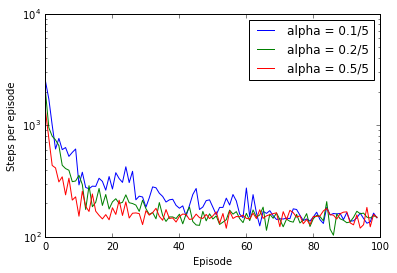

In [96]:
figureIndex = 0
# print learned cost to go
def prettyPrint(valueFunction, title):
    global figureIndex
    gridSize = 8  #
    positionStep = (POSITION_MAX - POSITION_MIN) / gridSize
    positions = np.arange(POSITION_MIN, POSITION_MAX + positionStep, positionStep)
    velocityStep = (VELOCITY_MAX - VELOCITY_MIN) / gridSize
    velocities = np.arange(VELOCITY_MIN, VELOCITY_MAX + velocityStep, velocityStep)
    axisX = []
    axisY = []
    axisZ = []
    for position in positions:
        for velocity in velocities:
            axisX.append(position)
            axisY.append(velocity)
            axisZ.append(valueFunction.costToGo(position, velocity))

    fig = plt.figure(figureIndex)
    figureIndex += 1
    fig.suptitle(title)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(axisX, axisY, axisZ)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Cost to go')

# Figure 10.1, cost to go in a single run
# def figure10_1():
# episodes = 100
# targetEpisodes = [0, 99, episodes - 1]
# numOfTilings = 8
# alpha = 0.3
# valueFunction = ValueFunction(alpha, numOfTilings)
# for episode in range(0, episodes):
#     ###print('episode:', episode)
#     semiGradientNStepSarsa(valueFunction)
#     if episode in targetEpisodes:
#         prettyPrint(valueFunction, 'Episode: ' + str(episode + 1))

# Figure 10.2, semi-gradient Sarsa with different alphas
#def figure10_2():
runs = 3
episodes = 100
numOfTilings = 5
alphas = [0.1, 0.2, 0.5]

thermos = np.zeros((3, episodes))  #####
steps = np.zeros((len(alphas), episodes))
for run in range(0, runs):
    valueFunctions = [ValueFunction(alpha, numOfTilings) for alpha in alphas]
    for index in range(0, len(valueFunctions)):
        for episode in range(0, episodes):
            ###print('run:', run, 'alpha:', alphas[index], 'episode:', episode)
            step, epis_S, epis_Q, epis_I = semiGradientNStepSarsa(valueFunctions[index])
            steps[index, episode] += step
            thermos[index, episode] += epis_I/(epis_S+epis_Q)

steps /= runs
thermos /= runs

global figureIndex
plt.figure(figureIndex)
figureIndex += 1
for i in range(0, len(alphas)):
    plt.plot(steps[i], label='alpha = '+str(alphas[i])+'/'+str(numOfTilings))
plt.xlabel('Episode')
plt.ylabel('Steps per episode')
plt.yscale('log')
plt.legend()
    
# figure10_1()
# figure10_2()

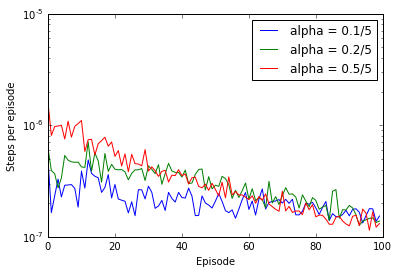

In [97]:
for i in range(0, len(alphas)):
    plt.plot(thermos[i], label='alpha = '+str(alphas[i])+'/'+str(numOfTilings))
plt.xlabel('Episode')
plt.ylabel('Steps per episode')
plt.yscale('log')
plt.legend()

run: 0 steps: 1 alpha: 0.25 episode: 0
run: 0 steps: 1 alpha: 0.25 episode: 1
run: 0 steps: 1 alpha: 0.25 episode: 2
run: 0 steps: 1 alpha: 0.25 episode: 3
run: 0 steps: 1 alpha: 0.25 episode: 4
run: 0 steps: 1 alpha: 0.25 episode: 5
run: 0 steps: 1 alpha: 0.25 episode: 6
run: 0 steps: 1 alpha: 0.25 episode: 7
run: 0 steps: 1 alpha: 0.25 episode: 8
run: 0 steps: 1 alpha: 0.25 episode: 9
run: 0 steps: 1 alpha: 0.25 episode: 10
run: 0 steps: 1 alpha: 0.25 episode: 11
run: 0 steps: 1 alpha: 0.25 episode: 12
run: 0 steps: 1 alpha: 0.25 episode: 13
run: 0 steps: 1 alpha: 0.25 episode: 14
run: 0 steps: 1 alpha: 0.25 episode: 15
run: 0 steps: 1 alpha: 0.25 episode: 16
run: 0 steps: 1 alpha: 0.25 episode: 17
run: 0 steps: 1 alpha: 0.25 episode: 18
run: 0 steps: 1 alpha: 0.25 episode: 19
run: 0 steps: 1 alpha: 0.25 episode: 20
run: 0 steps: 1 alpha: 0.25 episode: 21
run: 0 steps: 1 alpha: 0.25 episode: 22
run: 0 steps: 1 alpha: 0.25 episode: 23
run: 0 steps: 1 alpha: 0.25 episode: 24
run: 0 ste

run: 0 steps: 1 alpha: 1.25 episode: 9
run: 0 steps: 1 alpha: 1.25 episode: 10
run: 0 steps: 1 alpha: 1.25 episode: 11
run: 0 steps: 1 alpha: 1.25 episode: 12
run: 0 steps: 1 alpha: 1.25 episode: 13
run: 0 steps: 1 alpha: 1.25 episode: 14
run: 0 steps: 1 alpha: 1.25 episode: 15
run: 0 steps: 1 alpha: 1.25 episode: 16
run: 0 steps: 1 alpha: 1.25 episode: 17
run: 0 steps: 1 alpha: 1.25 episode: 18
run: 0 steps: 1 alpha: 1.25 episode: 19
run: 0 steps: 1 alpha: 1.25 episode: 20
run: 0 steps: 1 alpha: 1.25 episode: 21
run: 0 steps: 1 alpha: 1.25 episode: 22
run: 0 steps: 1 alpha: 1.25 episode: 23
run: 0 steps: 1 alpha: 1.25 episode: 24
run: 0 steps: 1 alpha: 1.25 episode: 25
run: 0 steps: 1 alpha: 1.25 episode: 26
run: 0 steps: 1 alpha: 1.25 episode: 27
run: 0 steps: 1 alpha: 1.25 episode: 28
run: 0 steps: 1 alpha: 1.25 episode: 29
run: 0 steps: 1 alpha: 1.25 episode: 30
run: 0 steps: 1 alpha: 1.25 episode: 31
run: 0 steps: 1 alpha: 1.25 episode: 32
run: 0 steps: 1 alpha: 1.25 episode: 33
r

run: 0 steps: 2 alpha: 0.75 episode: 18
run: 0 steps: 2 alpha: 0.75 episode: 19
run: 0 steps: 2 alpha: 0.75 episode: 20
run: 0 steps: 2 alpha: 0.75 episode: 21
run: 0 steps: 2 alpha: 0.75 episode: 22
run: 0 steps: 2 alpha: 0.75 episode: 23
run: 0 steps: 2 alpha: 0.75 episode: 24
run: 0 steps: 2 alpha: 0.75 episode: 25
run: 0 steps: 2 alpha: 0.75 episode: 26
run: 0 steps: 2 alpha: 0.75 episode: 27
run: 0 steps: 2 alpha: 0.75 episode: 28
run: 0 steps: 2 alpha: 0.75 episode: 29
run: 0 steps: 2 alpha: 0.75 episode: 30
run: 0 steps: 2 alpha: 0.75 episode: 31
run: 0 steps: 2 alpha: 0.75 episode: 32
run: 0 steps: 2 alpha: 0.75 episode: 33
run: 0 steps: 2 alpha: 0.75 episode: 34
run: 0 steps: 2 alpha: 0.75 episode: 35
run: 0 steps: 2 alpha: 0.75 episode: 36
run: 0 steps: 2 alpha: 0.75 episode: 37
run: 0 steps: 2 alpha: 0.75 episode: 38
run: 0 steps: 2 alpha: 0.75 episode: 39
run: 0 steps: 2 alpha: 0.75 episode: 40
run: 0 steps: 2 alpha: 0.75 episode: 41
run: 0 steps: 2 alpha: 0.75 episode: 42


run: 0 steps: 4 alpha: 0.25 episode: 27
run: 0 steps: 4 alpha: 0.25 episode: 28
run: 0 steps: 4 alpha: 0.25 episode: 29
run: 0 steps: 4 alpha: 0.25 episode: 30
run: 0 steps: 4 alpha: 0.25 episode: 31
run: 0 steps: 4 alpha: 0.25 episode: 32
run: 0 steps: 4 alpha: 0.25 episode: 33
run: 0 steps: 4 alpha: 0.25 episode: 34
run: 0 steps: 4 alpha: 0.25 episode: 35
run: 0 steps: 4 alpha: 0.25 episode: 36
run: 0 steps: 4 alpha: 0.25 episode: 37
run: 0 steps: 4 alpha: 0.25 episode: 38
run: 0 steps: 4 alpha: 0.25 episode: 39
run: 0 steps: 4 alpha: 0.25 episode: 40
run: 0 steps: 4 alpha: 0.25 episode: 41
run: 0 steps: 4 alpha: 0.25 episode: 42
run: 0 steps: 4 alpha: 0.25 episode: 43
run: 0 steps: 4 alpha: 0.25 episode: 44
run: 0 steps: 4 alpha: 0.25 episode: 45
run: 0 steps: 4 alpha: 0.25 episode: 46
run: 0 steps: 4 alpha: 0.25 episode: 47
run: 0 steps: 4 alpha: 0.25 episode: 48
run: 0 steps: 4 alpha: 0.25 episode: 49
run: 0 steps: 4 alpha: 0.5 episode: 0
run: 0 steps: 4 alpha: 0.5 episode: 1
run:

run: 0 steps: 4 alpha: 1.25 episode: 36
run: 0 steps: 4 alpha: 1.25 episode: 37
run: 0 steps: 4 alpha: 1.25 episode: 38
run: 0 steps: 4 alpha: 1.25 episode: 39
run: 0 steps: 4 alpha: 1.25 episode: 40
run: 0 steps: 4 alpha: 1.25 episode: 41
run: 0 steps: 4 alpha: 1.25 episode: 42
run: 0 steps: 4 alpha: 1.25 episode: 43
run: 0 steps: 4 alpha: 1.25 episode: 44
run: 0 steps: 4 alpha: 1.25 episode: 45
run: 0 steps: 4 alpha: 1.25 episode: 46
run: 0 steps: 4 alpha: 1.25 episode: 47
run: 0 steps: 4 alpha: 1.25 episode: 48
run: 0 steps: 4 alpha: 1.25 episode: 49
run: 0 steps: 4 alpha: 1.5 episode: 0
run: 0 steps: 4 alpha: 1.5 episode: 1
run: 0 steps: 4 alpha: 1.5 episode: 2
run: 0 steps: 4 alpha: 1.5 episode: 3
run: 0 steps: 4 alpha: 1.5 episode: 4
run: 0 steps: 4 alpha: 1.5 episode: 5
run: 0 steps: 4 alpha: 1.5 episode: 6
run: 0 steps: 4 alpha: 1.5 episode: 7
run: 0 steps: 4 alpha: 1.5 episode: 8
run: 0 steps: 4 alpha: 1.5 episode: 9
run: 0 steps: 4 alpha: 1.5 episode: 10
run: 0 steps: 4 alpha

run: 0 steps: 8 alpha: 0.75 episode: 45
run: 0 steps: 8 alpha: 0.75 episode: 46
run: 0 steps: 8 alpha: 0.75 episode: 47
run: 0 steps: 8 alpha: 0.75 episode: 48
run: 0 steps: 8 alpha: 0.75 episode: 49
run: 0 steps: 8 alpha: 1.0 episode: 0
run: 0 steps: 8 alpha: 1.0 episode: 1
run: 0 steps: 8 alpha: 1.0 episode: 2
run: 0 steps: 8 alpha: 1.0 episode: 3
run: 0 steps: 8 alpha: 1.0 episode: 4
run: 0 steps: 8 alpha: 1.0 episode: 5
run: 0 steps: 8 alpha: 1.0 episode: 6
run: 0 steps: 8 alpha: 1.0 episode: 7
run: 0 steps: 8 alpha: 1.0 episode: 8
run: 0 steps: 8 alpha: 1.0 episode: 9
run: 0 steps: 8 alpha: 1.0 episode: 10
run: 0 steps: 8 alpha: 1.0 episode: 11
run: 0 steps: 8 alpha: 1.0 episode: 12
run: 0 steps: 8 alpha: 1.0 episode: 13
run: 0 steps: 8 alpha: 1.0 episode: 14
run: 0 steps: 8 alpha: 1.0 episode: 15
run: 0 steps: 8 alpha: 1.0 episode: 16
run: 0 steps: 8 alpha: 1.0 episode: 17
run: 0 steps: 8 alpha: 1.0 episode: 18
run: 0 steps: 8 alpha: 1.0 episode: 19
run: 0 steps: 8 alpha: 1.0 epi

run: 1 steps: 1 alpha: 0.25 episode: 0
run: 1 steps: 1 alpha: 0.25 episode: 1
run: 1 steps: 1 alpha: 0.25 episode: 2
run: 1 steps: 1 alpha: 0.25 episode: 3
run: 1 steps: 1 alpha: 0.25 episode: 4
run: 1 steps: 1 alpha: 0.25 episode: 5
run: 1 steps: 1 alpha: 0.25 episode: 6
run: 1 steps: 1 alpha: 0.25 episode: 7
run: 1 steps: 1 alpha: 0.25 episode: 8
run: 1 steps: 1 alpha: 0.25 episode: 9
run: 1 steps: 1 alpha: 0.25 episode: 10
run: 1 steps: 1 alpha: 0.25 episode: 11
run: 1 steps: 1 alpha: 0.25 episode: 12
run: 1 steps: 1 alpha: 0.25 episode: 13
run: 1 steps: 1 alpha: 0.25 episode: 14
run: 1 steps: 1 alpha: 0.25 episode: 15
run: 1 steps: 1 alpha: 0.25 episode: 16
run: 1 steps: 1 alpha: 0.25 episode: 17
run: 1 steps: 1 alpha: 0.25 episode: 18
run: 1 steps: 1 alpha: 0.25 episode: 19
run: 1 steps: 1 alpha: 0.25 episode: 20
run: 1 steps: 1 alpha: 0.25 episode: 21
run: 1 steps: 1 alpha: 0.25 episode: 22
run: 1 steps: 1 alpha: 0.25 episode: 23
run: 1 steps: 1 alpha: 0.25 episode: 24
run: 1 ste

run: 1 steps: 1 alpha: 1.25 episode: 9
run: 1 steps: 1 alpha: 1.25 episode: 10
run: 1 steps: 1 alpha: 1.25 episode: 11
run: 1 steps: 1 alpha: 1.25 episode: 12
run: 1 steps: 1 alpha: 1.25 episode: 13
run: 1 steps: 1 alpha: 1.25 episode: 14
run: 1 steps: 1 alpha: 1.25 episode: 15
run: 1 steps: 1 alpha: 1.25 episode: 16
run: 1 steps: 1 alpha: 1.25 episode: 17
run: 1 steps: 1 alpha: 1.25 episode: 18
run: 1 steps: 1 alpha: 1.25 episode: 19
run: 1 steps: 1 alpha: 1.25 episode: 20
run: 1 steps: 1 alpha: 1.25 episode: 21
run: 1 steps: 1 alpha: 1.25 episode: 22
run: 1 steps: 1 alpha: 1.25 episode: 23
run: 1 steps: 1 alpha: 1.25 episode: 24
run: 1 steps: 1 alpha: 1.25 episode: 25
run: 1 steps: 1 alpha: 1.25 episode: 26
run: 1 steps: 1 alpha: 1.25 episode: 27
run: 1 steps: 1 alpha: 1.25 episode: 28
run: 1 steps: 1 alpha: 1.25 episode: 29
run: 1 steps: 1 alpha: 1.25 episode: 30
run: 1 steps: 1 alpha: 1.25 episode: 31
run: 1 steps: 1 alpha: 1.25 episode: 32
run: 1 steps: 1 alpha: 1.25 episode: 33
r

run: 1 steps: 2 alpha: 0.75 episode: 19
run: 1 steps: 2 alpha: 0.75 episode: 20
run: 1 steps: 2 alpha: 0.75 episode: 21
run: 1 steps: 2 alpha: 0.75 episode: 22
run: 1 steps: 2 alpha: 0.75 episode: 23
run: 1 steps: 2 alpha: 0.75 episode: 24
run: 1 steps: 2 alpha: 0.75 episode: 25
run: 1 steps: 2 alpha: 0.75 episode: 26
run: 1 steps: 2 alpha: 0.75 episode: 27
run: 1 steps: 2 alpha: 0.75 episode: 28
run: 1 steps: 2 alpha: 0.75 episode: 29
run: 1 steps: 2 alpha: 0.75 episode: 30
run: 1 steps: 2 alpha: 0.75 episode: 31
run: 1 steps: 2 alpha: 0.75 episode: 32
run: 1 steps: 2 alpha: 0.75 episode: 33
run: 1 steps: 2 alpha: 0.75 episode: 34
run: 1 steps: 2 alpha: 0.75 episode: 35
run: 1 steps: 2 alpha: 0.75 episode: 36
run: 1 steps: 2 alpha: 0.75 episode: 37
run: 1 steps: 2 alpha: 0.75 episode: 38
run: 1 steps: 2 alpha: 0.75 episode: 39
run: 1 steps: 2 alpha: 0.75 episode: 40
run: 1 steps: 2 alpha: 0.75 episode: 41
run: 1 steps: 2 alpha: 0.75 episode: 42
run: 1 steps: 2 alpha: 0.75 episode: 43


run: 1 steps: 4 alpha: 0.25 episode: 29
run: 1 steps: 4 alpha: 0.25 episode: 30
run: 1 steps: 4 alpha: 0.25 episode: 31
run: 1 steps: 4 alpha: 0.25 episode: 32
run: 1 steps: 4 alpha: 0.25 episode: 33
run: 1 steps: 4 alpha: 0.25 episode: 34
run: 1 steps: 4 alpha: 0.25 episode: 35
run: 1 steps: 4 alpha: 0.25 episode: 36
run: 1 steps: 4 alpha: 0.25 episode: 37
run: 1 steps: 4 alpha: 0.25 episode: 38
run: 1 steps: 4 alpha: 0.25 episode: 39
run: 1 steps: 4 alpha: 0.25 episode: 40
run: 1 steps: 4 alpha: 0.25 episode: 41
run: 1 steps: 4 alpha: 0.25 episode: 42
run: 1 steps: 4 alpha: 0.25 episode: 43
run: 1 steps: 4 alpha: 0.25 episode: 44
run: 1 steps: 4 alpha: 0.25 episode: 45
run: 1 steps: 4 alpha: 0.25 episode: 46
run: 1 steps: 4 alpha: 0.25 episode: 47
run: 1 steps: 4 alpha: 0.25 episode: 48
run: 1 steps: 4 alpha: 0.25 episode: 49
run: 1 steps: 4 alpha: 0.5 episode: 0
run: 1 steps: 4 alpha: 0.5 episode: 1
run: 1 steps: 4 alpha: 0.5 episode: 2
run: 1 steps: 4 alpha: 0.5 episode: 3
run: 1 s

run: 1 steps: 4 alpha: 1.25 episode: 38
run: 1 steps: 4 alpha: 1.25 episode: 39
run: 1 steps: 4 alpha: 1.25 episode: 40
run: 1 steps: 4 alpha: 1.25 episode: 41
run: 1 steps: 4 alpha: 1.25 episode: 42
run: 1 steps: 4 alpha: 1.25 episode: 43
run: 1 steps: 4 alpha: 1.25 episode: 44
run: 1 steps: 4 alpha: 1.25 episode: 45
run: 1 steps: 4 alpha: 1.25 episode: 46
run: 1 steps: 4 alpha: 1.25 episode: 47
run: 1 steps: 4 alpha: 1.25 episode: 48
run: 1 steps: 4 alpha: 1.25 episode: 49
run: 1 steps: 4 alpha: 1.5 episode: 0
run: 1 steps: 4 alpha: 1.5 episode: 1
run: 1 steps: 4 alpha: 1.5 episode: 2
run: 1 steps: 4 alpha: 1.5 episode: 3
run: 1 steps: 4 alpha: 1.5 episode: 4
run: 1 steps: 4 alpha: 1.5 episode: 5
run: 1 steps: 4 alpha: 1.5 episode: 6
run: 1 steps: 4 alpha: 1.5 episode: 7
run: 1 steps: 4 alpha: 1.5 episode: 8
run: 1 steps: 4 alpha: 1.5 episode: 9
run: 1 steps: 4 alpha: 1.5 episode: 10
run: 1 steps: 4 alpha: 1.5 episode: 11
run: 1 steps: 4 alpha: 1.5 episode: 12
run: 1 steps: 4 alpha: 

run: 1 steps: 8 alpha: 0.75 episode: 47
run: 1 steps: 8 alpha: 0.75 episode: 48
run: 1 steps: 8 alpha: 0.75 episode: 49
run: 1 steps: 8 alpha: 1.0 episode: 0
run: 1 steps: 8 alpha: 1.0 episode: 1
run: 1 steps: 8 alpha: 1.0 episode: 2
run: 1 steps: 8 alpha: 1.0 episode: 3
run: 1 steps: 8 alpha: 1.0 episode: 4
run: 1 steps: 8 alpha: 1.0 episode: 5
run: 1 steps: 8 alpha: 1.0 episode: 6
run: 1 steps: 8 alpha: 1.0 episode: 7
run: 1 steps: 8 alpha: 1.0 episode: 8
run: 1 steps: 8 alpha: 1.0 episode: 9
run: 1 steps: 8 alpha: 1.0 episode: 10
run: 1 steps: 8 alpha: 1.0 episode: 11
run: 1 steps: 8 alpha: 1.0 episode: 12
run: 1 steps: 8 alpha: 1.0 episode: 13
run: 1 steps: 8 alpha: 1.0 episode: 14
run: 1 steps: 8 alpha: 1.0 episode: 15
run: 1 steps: 8 alpha: 1.0 episode: 16
run: 1 steps: 8 alpha: 1.0 episode: 17
run: 1 steps: 8 alpha: 1.0 episode: 18
run: 1 steps: 8 alpha: 1.0 episode: 19
run: 1 steps: 8 alpha: 1.0 episode: 20
run: 1 steps: 8 alpha: 1.0 episode: 21
run: 1 steps: 8 alpha: 1.0 episo

run: 2 steps: 1 alpha: 0.25 episode: 2
run: 2 steps: 1 alpha: 0.25 episode: 3
run: 2 steps: 1 alpha: 0.25 episode: 4
run: 2 steps: 1 alpha: 0.25 episode: 5
run: 2 steps: 1 alpha: 0.25 episode: 6
run: 2 steps: 1 alpha: 0.25 episode: 7
run: 2 steps: 1 alpha: 0.25 episode: 8
run: 2 steps: 1 alpha: 0.25 episode: 9
run: 2 steps: 1 alpha: 0.25 episode: 10
run: 2 steps: 1 alpha: 0.25 episode: 11
run: 2 steps: 1 alpha: 0.25 episode: 12
run: 2 steps: 1 alpha: 0.25 episode: 13
run: 2 steps: 1 alpha: 0.25 episode: 14
run: 2 steps: 1 alpha: 0.25 episode: 15
run: 2 steps: 1 alpha: 0.25 episode: 16
run: 2 steps: 1 alpha: 0.25 episode: 17
run: 2 steps: 1 alpha: 0.25 episode: 18
run: 2 steps: 1 alpha: 0.25 episode: 19
run: 2 steps: 1 alpha: 0.25 episode: 20
run: 2 steps: 1 alpha: 0.25 episode: 21
run: 2 steps: 1 alpha: 0.25 episode: 22
run: 2 steps: 1 alpha: 0.25 episode: 23
run: 2 steps: 1 alpha: 0.25 episode: 24
run: 2 steps: 1 alpha: 0.25 episode: 25
run: 2 steps: 1 alpha: 0.25 episode: 26
run: 2 s

run: 2 steps: 1 alpha: 1.25 episode: 12
run: 2 steps: 1 alpha: 1.25 episode: 13
run: 2 steps: 1 alpha: 1.25 episode: 14
run: 2 steps: 1 alpha: 1.25 episode: 15
run: 2 steps: 1 alpha: 1.25 episode: 16
run: 2 steps: 1 alpha: 1.25 episode: 17
run: 2 steps: 1 alpha: 1.25 episode: 18
run: 2 steps: 1 alpha: 1.25 episode: 19
run: 2 steps: 1 alpha: 1.25 episode: 20
run: 2 steps: 1 alpha: 1.25 episode: 21
run: 2 steps: 1 alpha: 1.25 episode: 22
run: 2 steps: 1 alpha: 1.25 episode: 23
run: 2 steps: 1 alpha: 1.25 episode: 24
run: 2 steps: 1 alpha: 1.25 episode: 25
run: 2 steps: 1 alpha: 1.25 episode: 26
run: 2 steps: 1 alpha: 1.25 episode: 27
run: 2 steps: 1 alpha: 1.25 episode: 28
run: 2 steps: 1 alpha: 1.25 episode: 29
run: 2 steps: 1 alpha: 1.25 episode: 30
run: 2 steps: 1 alpha: 1.25 episode: 31
run: 2 steps: 1 alpha: 1.25 episode: 32
run: 2 steps: 1 alpha: 1.25 episode: 33
run: 2 steps: 1 alpha: 1.25 episode: 34
run: 2 steps: 1 alpha: 1.25 episode: 35
run: 2 steps: 1 alpha: 1.25 episode: 36


run: 2 steps: 2 alpha: 0.75 episode: 21
run: 2 steps: 2 alpha: 0.75 episode: 22
run: 2 steps: 2 alpha: 0.75 episode: 23
run: 2 steps: 2 alpha: 0.75 episode: 24
run: 2 steps: 2 alpha: 0.75 episode: 25
run: 2 steps: 2 alpha: 0.75 episode: 26
run: 2 steps: 2 alpha: 0.75 episode: 27
run: 2 steps: 2 alpha: 0.75 episode: 28
run: 2 steps: 2 alpha: 0.75 episode: 29
run: 2 steps: 2 alpha: 0.75 episode: 30
run: 2 steps: 2 alpha: 0.75 episode: 31
run: 2 steps: 2 alpha: 0.75 episode: 32
run: 2 steps: 2 alpha: 0.75 episode: 33
run: 2 steps: 2 alpha: 0.75 episode: 34
run: 2 steps: 2 alpha: 0.75 episode: 35
run: 2 steps: 2 alpha: 0.75 episode: 36
run: 2 steps: 2 alpha: 0.75 episode: 37
run: 2 steps: 2 alpha: 0.75 episode: 38
run: 2 steps: 2 alpha: 0.75 episode: 39
run: 2 steps: 2 alpha: 0.75 episode: 40
run: 2 steps: 2 alpha: 0.75 episode: 41
run: 2 steps: 2 alpha: 0.75 episode: 42
run: 2 steps: 2 alpha: 0.75 episode: 43
run: 2 steps: 2 alpha: 0.75 episode: 44
run: 2 steps: 2 alpha: 0.75 episode: 45


run: 2 steps: 4 alpha: 0.25 episode: 31
run: 2 steps: 4 alpha: 0.25 episode: 32
run: 2 steps: 4 alpha: 0.25 episode: 33
run: 2 steps: 4 alpha: 0.25 episode: 34
run: 2 steps: 4 alpha: 0.25 episode: 35
run: 2 steps: 4 alpha: 0.25 episode: 36
run: 2 steps: 4 alpha: 0.25 episode: 37
run: 2 steps: 4 alpha: 0.25 episode: 38
run: 2 steps: 4 alpha: 0.25 episode: 39
run: 2 steps: 4 alpha: 0.25 episode: 40
run: 2 steps: 4 alpha: 0.25 episode: 41
run: 2 steps: 4 alpha: 0.25 episode: 42
run: 2 steps: 4 alpha: 0.25 episode: 43
run: 2 steps: 4 alpha: 0.25 episode: 44
run: 2 steps: 4 alpha: 0.25 episode: 45
run: 2 steps: 4 alpha: 0.25 episode: 46
run: 2 steps: 4 alpha: 0.25 episode: 47
run: 2 steps: 4 alpha: 0.25 episode: 48
run: 2 steps: 4 alpha: 0.25 episode: 49
run: 2 steps: 4 alpha: 0.5 episode: 0
run: 2 steps: 4 alpha: 0.5 episode: 1
run: 2 steps: 4 alpha: 0.5 episode: 2
run: 2 steps: 4 alpha: 0.5 episode: 3
run: 2 steps: 4 alpha: 0.5 episode: 4
run: 2 steps: 4 alpha: 0.5 episode: 5
run: 2 steps

run: 2 steps: 4 alpha: 1.25 episode: 41
run: 2 steps: 4 alpha: 1.25 episode: 42
run: 2 steps: 4 alpha: 1.25 episode: 43
run: 2 steps: 4 alpha: 1.25 episode: 44
run: 2 steps: 4 alpha: 1.25 episode: 45
run: 2 steps: 4 alpha: 1.25 episode: 46
run: 2 steps: 4 alpha: 1.25 episode: 47
run: 2 steps: 4 alpha: 1.25 episode: 48
run: 2 steps: 4 alpha: 1.25 episode: 49
run: 2 steps: 4 alpha: 1.5 episode: 0
run: 2 steps: 4 alpha: 1.5 episode: 1
run: 2 steps: 4 alpha: 1.5 episode: 2
run: 2 steps: 4 alpha: 1.5 episode: 3
run: 2 steps: 4 alpha: 1.5 episode: 4
run: 2 steps: 4 alpha: 1.5 episode: 5
run: 2 steps: 4 alpha: 1.5 episode: 6
run: 2 steps: 4 alpha: 1.5 episode: 7
run: 2 steps: 4 alpha: 1.5 episode: 8
run: 2 steps: 4 alpha: 1.5 episode: 9
run: 2 steps: 4 alpha: 1.5 episode: 10
run: 2 steps: 4 alpha: 1.5 episode: 11
run: 2 steps: 4 alpha: 1.5 episode: 12
run: 2 steps: 4 alpha: 1.5 episode: 13
run: 2 steps: 4 alpha: 1.5 episode: 14
run: 2 steps: 4 alpha: 1.5 episode: 15
run: 2 steps: 4 alpha: 1.5

run: 2 steps: 8 alpha: 1.0 episode: 0
run: 2 steps: 8 alpha: 1.0 episode: 1
run: 2 steps: 8 alpha: 1.0 episode: 2
run: 2 steps: 8 alpha: 1.0 episode: 3
run: 2 steps: 8 alpha: 1.0 episode: 4
run: 2 steps: 8 alpha: 1.0 episode: 5
run: 2 steps: 8 alpha: 1.0 episode: 6
run: 2 steps: 8 alpha: 1.0 episode: 7
run: 2 steps: 8 alpha: 1.0 episode: 8
run: 2 steps: 8 alpha: 1.0 episode: 9
run: 2 steps: 8 alpha: 1.0 episode: 10
run: 2 steps: 8 alpha: 1.0 episode: 11
run: 2 steps: 8 alpha: 1.0 episode: 12
run: 2 steps: 8 alpha: 1.0 episode: 13
run: 2 steps: 8 alpha: 1.0 episode: 14
run: 2 steps: 8 alpha: 1.0 episode: 15
run: 2 steps: 8 alpha: 1.0 episode: 16
run: 2 steps: 8 alpha: 1.0 episode: 17
run: 2 steps: 8 alpha: 1.0 episode: 18
run: 2 steps: 8 alpha: 1.0 episode: 19
run: 2 steps: 8 alpha: 1.0 episode: 20
run: 2 steps: 8 alpha: 1.0 episode: 21
run: 2 steps: 8 alpha: 1.0 episode: 22
run: 2 steps: 8 alpha: 1.0 episode: 23
run: 2 steps: 8 alpha: 1.0 episode: 24
run: 2 steps: 8 alpha: 1.0 episode:

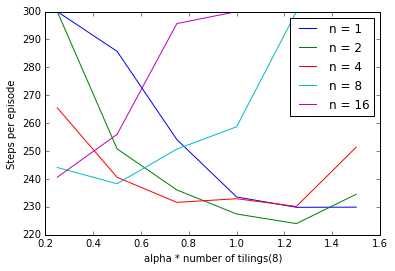

In [106]:
alphas = np.arange(0.25, 1.75, 0.25)
nSteps = np.power(2, np.arange(0, 5))
episodes = 50
runs = 3

truncateStep = 300
steps = np.zeros((len(nSteps), len(alphas)))
thermos = np.zeros((len(nSteps), len(alphas)))  #####
for run in range(0, runs):
    for nStepIndex, nStep in zip(range(0, len(nSteps)), nSteps):
        for alphaIndex, alpha in zip(range(0, len(alphas)), alphas):
            if (nStep == 8 and alpha > 1) or \
                    (nStep == 16 and alpha > 0.75):
                # In these cases it won't converge, so ignore them
                steps[nStepIndex, alphaIndex] += truncateStep * episodes
                continue
            valueFunction = ValueFunction(alpha)
            for episode in range(0, episodes):
                print('run:', run, 'steps:', nStep, 'alpha:', alpha, 'episode:', episode)
                step, epis_S, epis_Q, epis_I = semiGradientNStepSarsa(valueFunction, nStep)
                steps[nStepIndex, alphaIndex] += step
                thermos[nStepIndex, alphaIndex] += epis_I/(epis_S+epis_Q)
                
# average over independent runs and episodes
steps /= runs * episodes
thermos /= runs * episodes
# truncate high values for better display
steps[steps > truncateStep] = truncateStep

global figureIndex
plt.figure(figureIndex)
figureIndex += 1
for i in range(0, len(nSteps)):
    plt.plot(alphas, steps[i, :], label='n = '+str(nSteps[i]))
plt.xlabel('alpha * number of tilings(8)')
plt.ylabel('Steps per episode')
plt.legend()

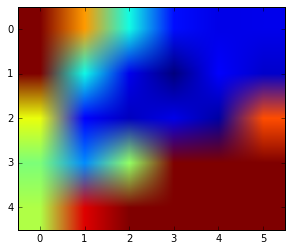

In [102]:
plt.imshow(steps)

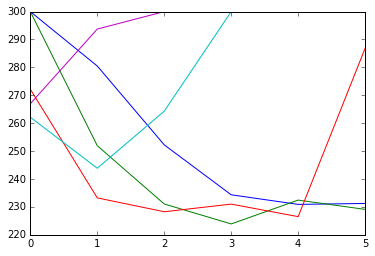

In [104]:
plt.plot(steps.T)

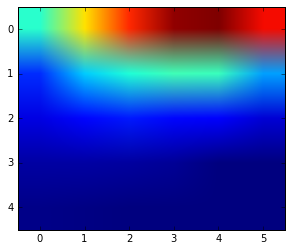

In [108]:
plt.imshow(thermos)

# Polynomial Fit

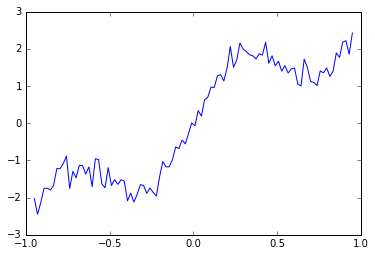

In [3]:
N_train = 100

sigma_train = .2

xx = np.linspace(-0.95,0.95,N_train)

ss = sigma_train*np.random.randn(N_train)

#function f
true_y = 3*xx + np.sin(6*xx) + ss

plt.plot(xx,true_y)

In [11]:
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def calc_H(x, bins):
    c_x = np.histogram(x,bins)[0]
    H = entropy(c_x)
    return H

In [5]:
def predict(params):
    p = params
    #xx = np.linspace(0.05,0.95,N_train)
    pred_y = p[0]*xx + np.sin(p[1]*xx)
    return pred_y

In [6]:
###derivative of the energy function == d_E/d_theta
def dfunc(params):
    grad = np.zeros(len(params))
    p = params
    pred_y = predict(p)
    ### pred_y = p[0]*xx + xx**p[1] + p[2]*np.sin(p[3]*xx)  ### take derivative for each parameter
    d1 = xx
    d2 = p[1]*np.cos(p[1]*xx)
    grad[0] = np.mean((pred_y - true_y)*d1)
    grad[1] = np.mean((pred_y - true_y)*d2)
    
    return grad

In [32]:
###Hessian for quasi-Newton method
def HH(params):
    H = np.zeros((len(params),len(params)))
    p = params
    pred_y = predict(p)
    ### pred_y = p[0]*xx + np.sin(p[1]*xx)
    H[0,0] = np.mean(xx**2)  #d2f/dada
    H[1,0] = np.mean(xx**2*np.cos(p[1]*xx))  #d2f/dadb
    H[0,1] = np.mean(xx**2*np.cos(p[1]*xx))  #d2f/dbda
    H[1,1] = np.mean(-p[0]*xx**3*np.sin(p[1]*xx) - xx**2*true_y*np.sin(p[1]*xx) + xx**2*(np.cos(p[1]*xx)**2 - np.sin(p[1]*xx)**2))  #d2f/dbdb
    H = np.linalg.inv(H)
    return H
    

In [7]:
def Energy(params):
    pred_y = predict(params)
    E = np.sum(0.5*(pred_y - true_y)**2)
    return E

In [44]:
def SGD(theta0, n_epochs=1000, eta=10**-4, noise_strength=0):
    params = np.array(theta0)
    param_traj = np.zeros([n_epochs+1,len(theta0)])
    E_traj = np.zeros(n_epochs+1)
    param_traj[0,] = theta0
    E_traj[0] = Energy(params)
    MI_traj = np.zeros(n_epochs+1)
    v=0;
    for j in range(n_epochs):
        noise = noise_strength*np.random.randn(params.size)
        #v = eta*(np.array(dfunc(params)) + noise)  #SGD
        #v = 0.1*v+eta*(np.array(dfunc(params))+noise)  #adding moments
        v = eta*(HH(params) @ dfunc(params) + noise)  #quasi-Newton method
        oldp = params.copy()
        oldy = predict(oldp)
        params = params - v
        newy = predict(params)
        param_traj[j+1,] = params
        E_traj[j+1] = Energy(params)
        MI_traj[j+1] = 0#calc_MI(oldy,newy,10)
    return param_traj, E_traj, MI_traj

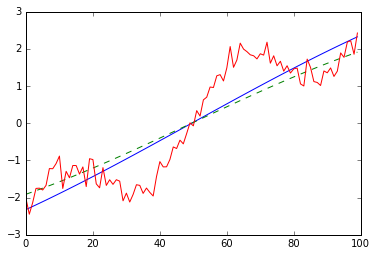

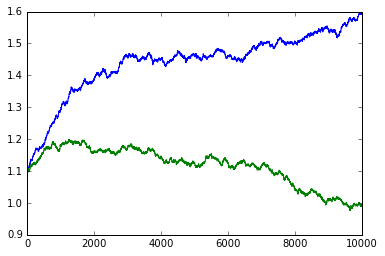

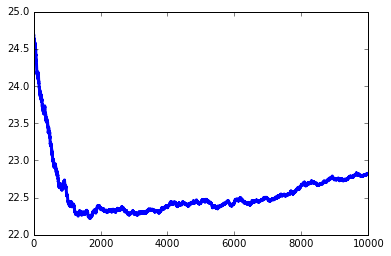

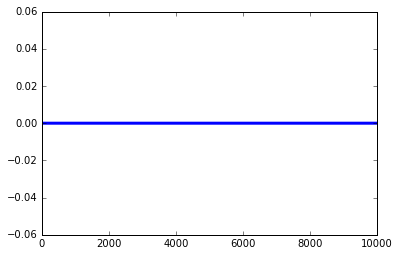

In [47]:
theta0 = np.array([1.1,1.1])  #np.random.rand(2)*1  #
param_traj, E_traj, MI_traj = SGD(theta0, n_epochs=10000, eta=10**-3, noise_strength=1)

plt.plot(predict(param_traj[-1,:]))
plt.hold(True)
plt.plot(predict(theta0),'--')
plt.plot(true_y)
plt.figure()
plt.plot(param_traj)
plt.figure()
plt.plot(E_traj,linewidth=3)
plt.figure()
plt.plot(MI_traj,linewidth=3)

In [50]:
HH([3,6])

array([[3.27090597, 0.14137898],
       [0.14137898, 1.58258231]])

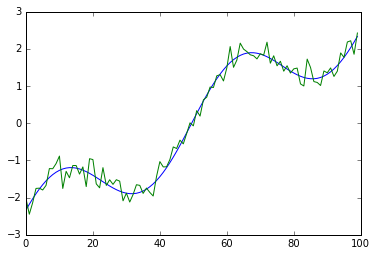

In [18]:
from scipy.optimize import minimize
theta0 = np.random.rand(2)*1  #np.array([1.1,5.1])  #
res = minimize(Energy, theta0)
plt.plot(predict(res.x))
plt.hold(True)
plt.plot(true_y)

In [51]:
res.hess_inv

array([[0.03286754, 0.00475721],
       [0.00475721, 0.08132797]])

# Adaptive Subunit Model

## $\dot{\alpha_i} = \frac{(1-\alpha_i)}{\tau_{slow}} - \alpha_iI_i(t)$

## $\tau_{fast} \dot{v_i} = -v_i + [\alpha_iv_i + I_i(t)]_+$

## $r(t) = \sum_{i=1}^{S}v_i(t)$

$\alpha_i = \text{adaptive variable of subunit, } \alpha_i \in [0,1]$

$\tau_{slow} = 10 \text{ sec}$

$I_i = \text{input to subunit } i$

$v_i = \text{spike rate of subunit } i$

$\tau_{fast} = 0.1  \text{ sec}$

$r = \text{spike rate of a simple cell}$

$S=\text{# of frames in a sequence}$

In [2]:
###Stimuli
dt = 0.01
T = 30
tt = np.arange(0,T,dt)

S = np.arange(0,4,1)
L = 15
marks = []
for ll in range(0,L):
    marks = np.append(marks,S[:-1])

temp = np.append(marks,S[-1])
marks = np.append(temp,marks)

dur = 0.2
ratio = int(dur/dt)
stimuli = []
for ii in range(0,len(marks)):
    stimuli = np.append(stimuli,marks[ii]*np.ones(ratio))

stimuli = stimuli + 1
    
k = len(tt)-len(stimuli)
if k < 0:
    stimuli = stimuli[:len(tt)]
else:
    stimuli = np.append(stimuli,np.zeros(k))

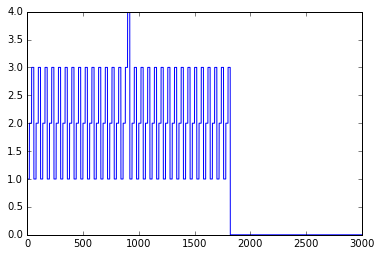

In [3]:
plt.plot(stimuli)

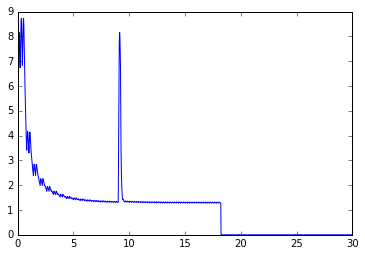

In [4]:
###adpative subunits
subu = len(S)
xs = np.zeros((subu,len(tt)))
vs = np.zeros((subu,len(tt)))
xs[:,0] = 1
vs[:,0] = 0
r = np.zeros(len(tt))

A = 1
tauS = 10
tauF = 0.01

for t in range(0,len(tt)-1):
    I = np.zeros(subu)
    if int(stimuli[t]) >0: 
        I[int(stimuli[t])-1] = A
    xs[:,t+1] = xs[:,t] + ((1-xs[:,t])/tauS - np.multiply(xs[:,t],I)) *dt
    vs[:,t+1] = vs[:,t] + (-vs[:,t] + np.multiply(xs[:,t],vs[:,t]) + I)/tauF *dt
    #vs[:,t] = np.multiply(xs[:,t],I)
    r[t+1] = np.sum(vs[:,t])
    
plt.plot(tt,r)

# With Anti-Hebb network

In [52]:
#learning parameters
alpha = 0.05
beta = 0.01
gamma = 0.1
lamb = 1
p = 0.05
q = 0.02
dt = .01  #10 ms as a bin!!
T = int(100/dt)
time = np.arange(0,T*dt,dt)

In [80]:
#subunits
Ns = 20  #neurons
subs = 10  #subunits per neuron
stimn = 10  #stimuli area
olap = 1-0.2  #squeezed/shared representation (0-1)
allsub = int(Ns*subs*olap)
nn = allsub  #total number of subunits

#parameters
A = 5
tauS = 10
tauF = 0.01


In [81]:
#connectivity
Qc = np.zeros((Ns,nn))  #connectivity for shared sub-units to neurons
W = np.zeros((Ns,Ns))  #neural layer with anti-Hebbian dynamics

for i in range(0,Ns):
    temp = np.random.randint(nn,size = subs)
    Qc[i,temp] = 1

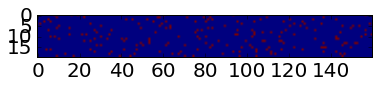

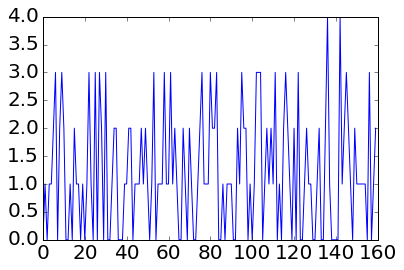

In [82]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.imshow(Qc)
plt.figure()
plt.plot(Qc.sum(0))

In [83]:
###Stimuli
import numpy.matlib
#marks
fnum = 4
mark = np.arange(0,fnum,1) + 1
dur = 20
mark2 = np.repeat(mark,dur,axis=0)
L = 25
marks = np.matlib.repmat(np.expand_dims(mark2,axis=1),L,1)

#extended
wait = 1500
marks = np.concatenate((np.zeros((wait,1)),marks,marks+fnum,marks+fnum*2,marks+fnum*3),axis=0)
#marks = np.concatenate((marks,marks+fnum),axis=0)

#fixing length
if len(marks)<T:
    marks = np.concatenate((marks,np.zeros((T-len(marks),1))),axis=0)
elif len(marks)>T:
    marks = marks[0:T]

In [84]:
#filling patterns
II = np.zeros((T,nn))
patterns = np.random.randint(nn,size=(stimn,int(np.max(marks)+1)))
patterns = np.concatenate((np.zeros((stimn,1)),patterns),axis=1)
for ii in range(0,T):
    index = int(marks[ii])
    if index==0:
        II[ii,np.random.choice(nn,stimn)] = A  #relaxation under random input
    else:
        #II = [II[ii,j]=A for j in patterns[:,index]]
        indx = list(patterns[:,index].astype(int))
        II[ii,indx] = A

In [85]:
###subunits with anti-Hebb
#intialization
xs = np.zeros((nn,T))
vs = np.zeros((nn,T))
xs[:,0] = 1
vs[:,0] = 0
r = np.zeros((Ns,T))
th = np.zeros((Ns,T))
W = np.zeros((Ns,Ns))  #neural layer with anti-Hebbian dynamics

def NL_function(x,lamb):
    f = 1/(1+np.exp(-lamb*x))
    return f

#iteration
for t in range(0,T-1):
    xs[:,t+1] = xs[:,t] + ((1-xs[:,t])/tauS - np.multiply(xs[:,t],II[t,:])) *dt
    vs[:,t+1] = vs[:,t] + (-vs[:,t] + np.multiply(xs[:,t],vs[:,t]) + II[t,:])/tauF *dt
    #vs[:,t] = np.multiply(xs[:,t],I)
    #r[:,t+1] = vs[:,t] @ Qc.T
    
    r[:,t+1] = r[:,t] + dt*(NL_function(vs[:,t] @ Qc.T + W @ r[:,t] - th[:,t] , lamb) - r[:,t]/0.5)  #neural
    W = W + -alpha* (np.outer(r[:,t+1], r[:,t+1]) - p)  #anti-Hebb
    np.fill_diagonal(W,np.zeros(W.shape[0]),int)
    W[W>0] = 0
    #Q = np.eye(nn)#Q + beta* y[tt,:] @ (x[tt,:]-Q)  #Hebb
    th[:,t+1] = th[:,t] + gamma* (r[:,t]-q)


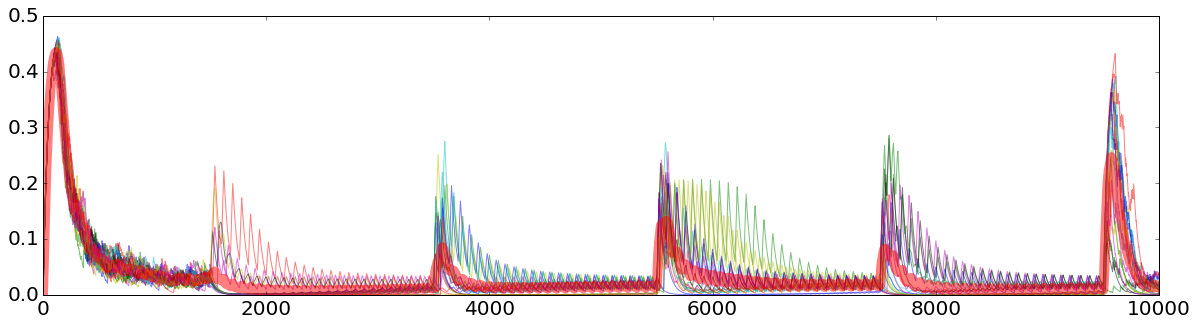

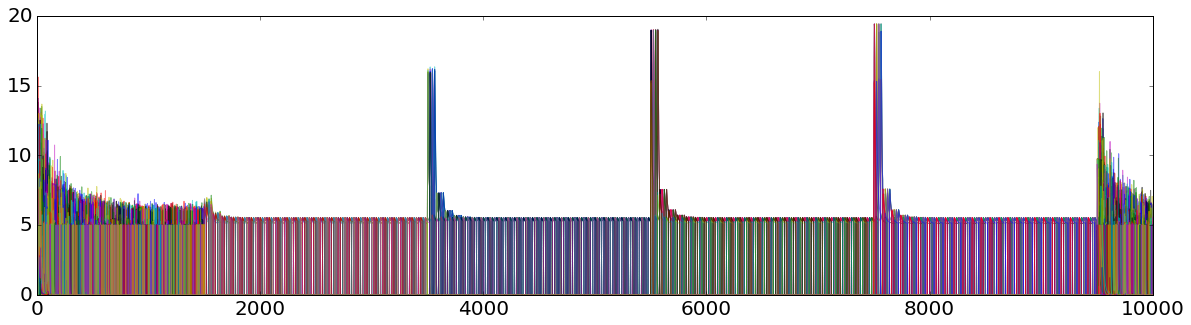

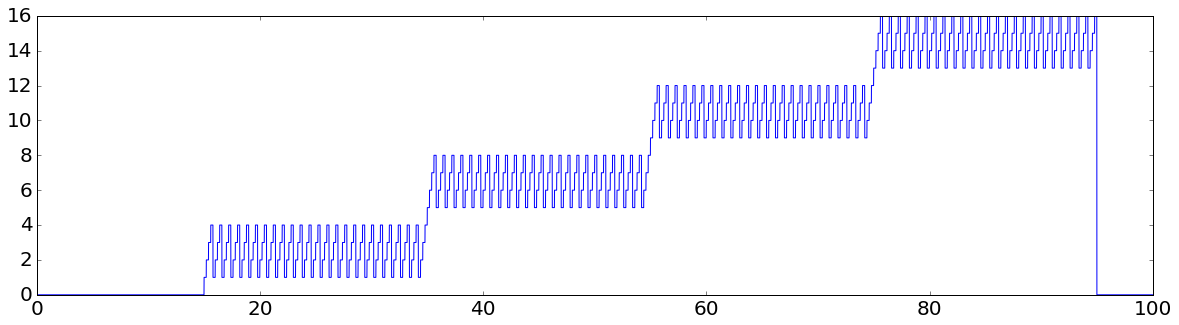

In [86]:
plt.figure(figsize=(20,5))
#plt.plot(vs.sum(0));
plt.plot(r.T,alpha=0.5);
plt.plot(r.mean(0),alpha=0.5,linewidth=10,color='red');
plt.figure(figsize=(20,5))
plt.plot(vs.T,alpha=0.5);

plt.figure(figsize=(20,5))
plt.plot(time,marks)

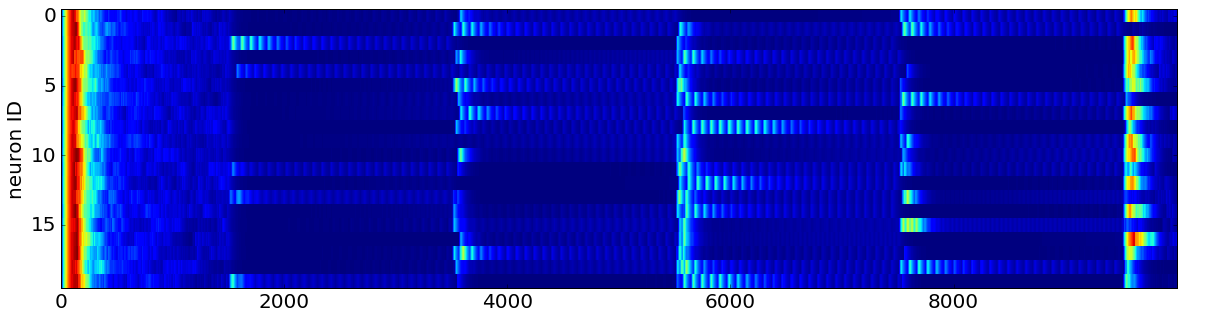

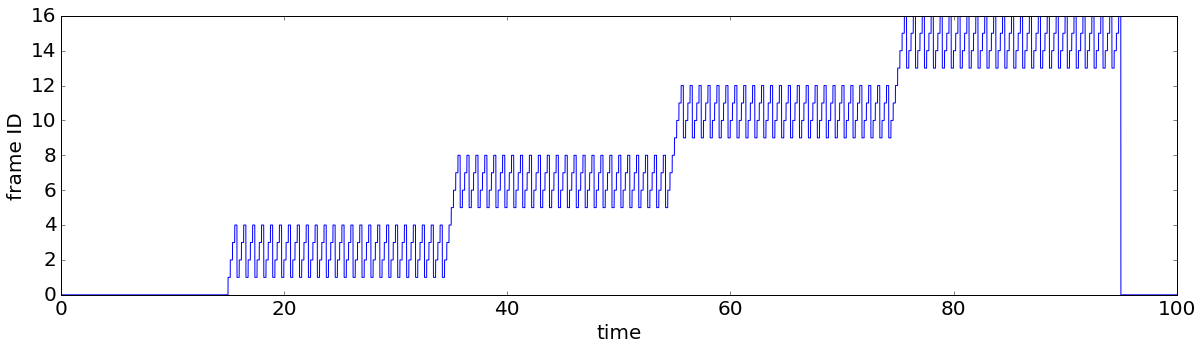

In [87]:
plt.figure(figsize=(20,5))
#plt.plot(vs.sum(0));
plt.imshow(r,interpolation='nearest', aspect='auto');
# plt.plot(r.mean(0),alpha=0.5,linewidth=10,color='red');
# plt.figure(figsize=(20,5))
# plt.plot(vs.T,alpha=0.5);
plt.ylabel('neuron ID')

# plt.figure(figsize=(20,5))
# plt.plot(time,marks)
plt.figure(figsize=(20,5))
plt.plot(time,marks)
plt.xlabel('time')
plt.ylabel('frame ID')

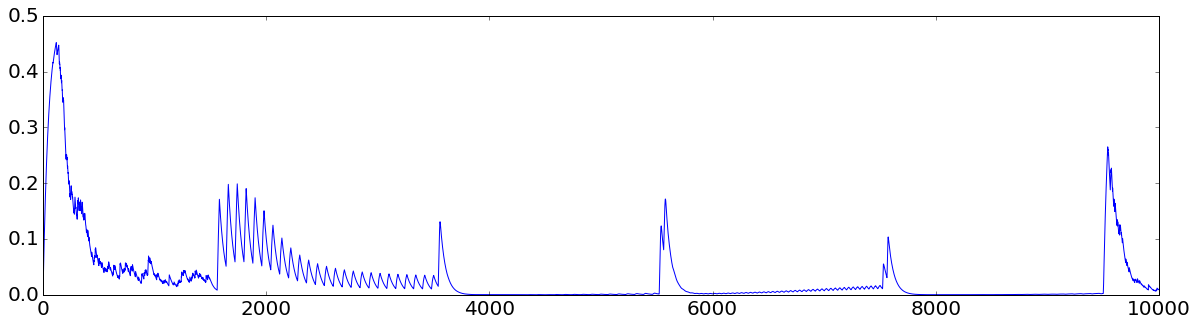

In [66]:
plt.figure(figsize=(20,5))
plt.plot(r[15,:])

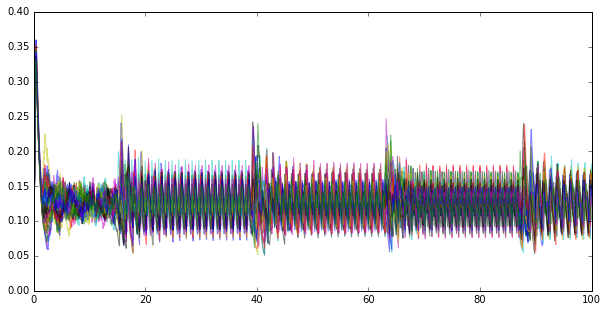

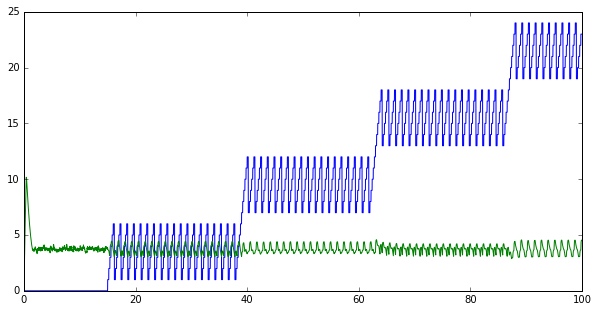

In [11]:
import numpy.matlib

#learning parameters
alpha = 0.5
beta = 0.01
gamma = 0.02
lamb = 2
p = 1/8
dt = .01
T = int(100/dt)
time = np.arange(0,T*dt,dt)

#neural network
nn = 30
W = np.random.rand(nn,nn)#np.zeros((nn,nn))#
Q = np.random.rand(nn,nn)
y = np.zeros((T,nn))
th = np.zeros((T,nn))
def NL_function(x,lamb):
    f = 1/(1+np.exp(-lamb*x))
    return f

### stimuli ###
#marks
fnum = 6
mark = np.arange(0,fnum,1) + 1
dur = 20
mark2 = np.repeat(mark,dur,axis=0)
L = 20
marks = np.matlib.repmat(np.expand_dims(mark2,axis=1),L,1)

#extended
wait = 1500
marks = np.concatenate((np.zeros((wait,1)),marks,marks+fnum,marks+fnum*2,marks+fnum*3),axis=0)
#marks = np.concatenate((marks,marks+fnum),axis=0)

#fixing length
if len(marks)<T:
    marks = np.concatenate((marks,np.zeros((T-len(marks),1))),axis=0)
elif len(marks)>T:
    marks = marks[0:T]

#filling patterns
x = np.zeros((T,nn))
patterns = np.random.randint(2,size=(nn,int(np.max(marks)+1)))
patterns = np.concatenate((np.zeros((nn,1)),patterns),axis=1)
for ii in range(0,T):
    index = int(marks[ii])
    if index==0:
        x[ii,:] = np.squeeze(np.random.randint(2,size=(nn,1)))  #relaxation under random input
    else:
        stimuli = patterns[:,index]  #sequence patterns
        x[ii,:] = stimuli

#dynamics
for tt in range(0,T-1):
    temp = y[tt,:] + dt*(NL_function(Q @ x[tt,:] + W @ y[tt,:] - th[tt,:] , lamb) - y[tt,:]/1)  #neural
    #temp[temp>=0.5] = 1
    #temp[temp<0.5] = 0
    y[tt+1,:] = temp
    W = W + -alpha* (np.outer(y[tt,:], y[tt,:]) - p**2)  #anti-Hebb
    np.fill_diagonal(W,np.zeros(W.shape[0]),int)
    W[W>0] = 0
    #Q = np.eye(nn)#Q + beta* y[tt,:] @ (x[tt,:]-Q)  #Hebb
    th[tt+1,:] = th[tt,:] + gamma* (y[tt,:]-p)  #threshold
     
#plot
plt.figure(figsize=(10,5))
plt.plot(time,y,alpha=0.5);
plt.figure(figsize=(10,5))
plt.plot(time,marks)
plt.hold(True)
plt.plot(time,y.sum(1))
#plt.figure(figsize=(10,10))
#plt.imshow(y[0:5000,:].T,interpolation='nearest', aspect='auto')